# Course Project &mdash; Isaac Joffe and Benjamin Colussi

### CS 679: Neural Networks


## Introduction

This auxiliary Jupyter notebook breaks down our reimplementation of [MONet](https://arxiv.org/abs/1901.11390), presented by Burgess et al. in "MONet: Unsupervised Scene Decomposition and Representation", in detail.

This notebook goes through each part of our code for the model, explaining how it works and why we constructed it that way.


In [1]:
# Isaac Joffe and Benjamin Colussi, 2025


# Fundamental PyTorch utilities to build model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms as T
# Libraries to use datasets
from multi_object_datasets_torch import ClevrWithMasks, MultiDSprites, ObjectsRoom, Tetrominoes
from multi_object_datasets_torch import flatten_and_one_hot, adjusted_rand_index
from arc_data import ARCAGI
# Additional common libraries
import matplotlib.pyplot as plt
import os
from time import time
from tqdm import tqdm
import argparse


# Get GPU information
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device being used: {device}")
if device == "cuda":
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    torch.backends.cudnn.benchmark = True


Device being used: cpu


## Model Architecture

### Summary

Fundamentally, MONet consists of two neural networks (NNs): a variational auto-encoder (VAE) and an attention network. The attention network is invoked recurrently to decompose the image into different slots, while the VAE represents and reconstructs each slot. MONet is trained and inferenced end-to-end (i.e., based on an entire forward pass and a loss function that accounts for all slots together) in an entirely unsupervised manner (i.e., based only on raw images without any explicit labels).

The main figure in the [original paper](https://arxiv.org/abs/1901.11390) summarizes the structure of the model excellently:

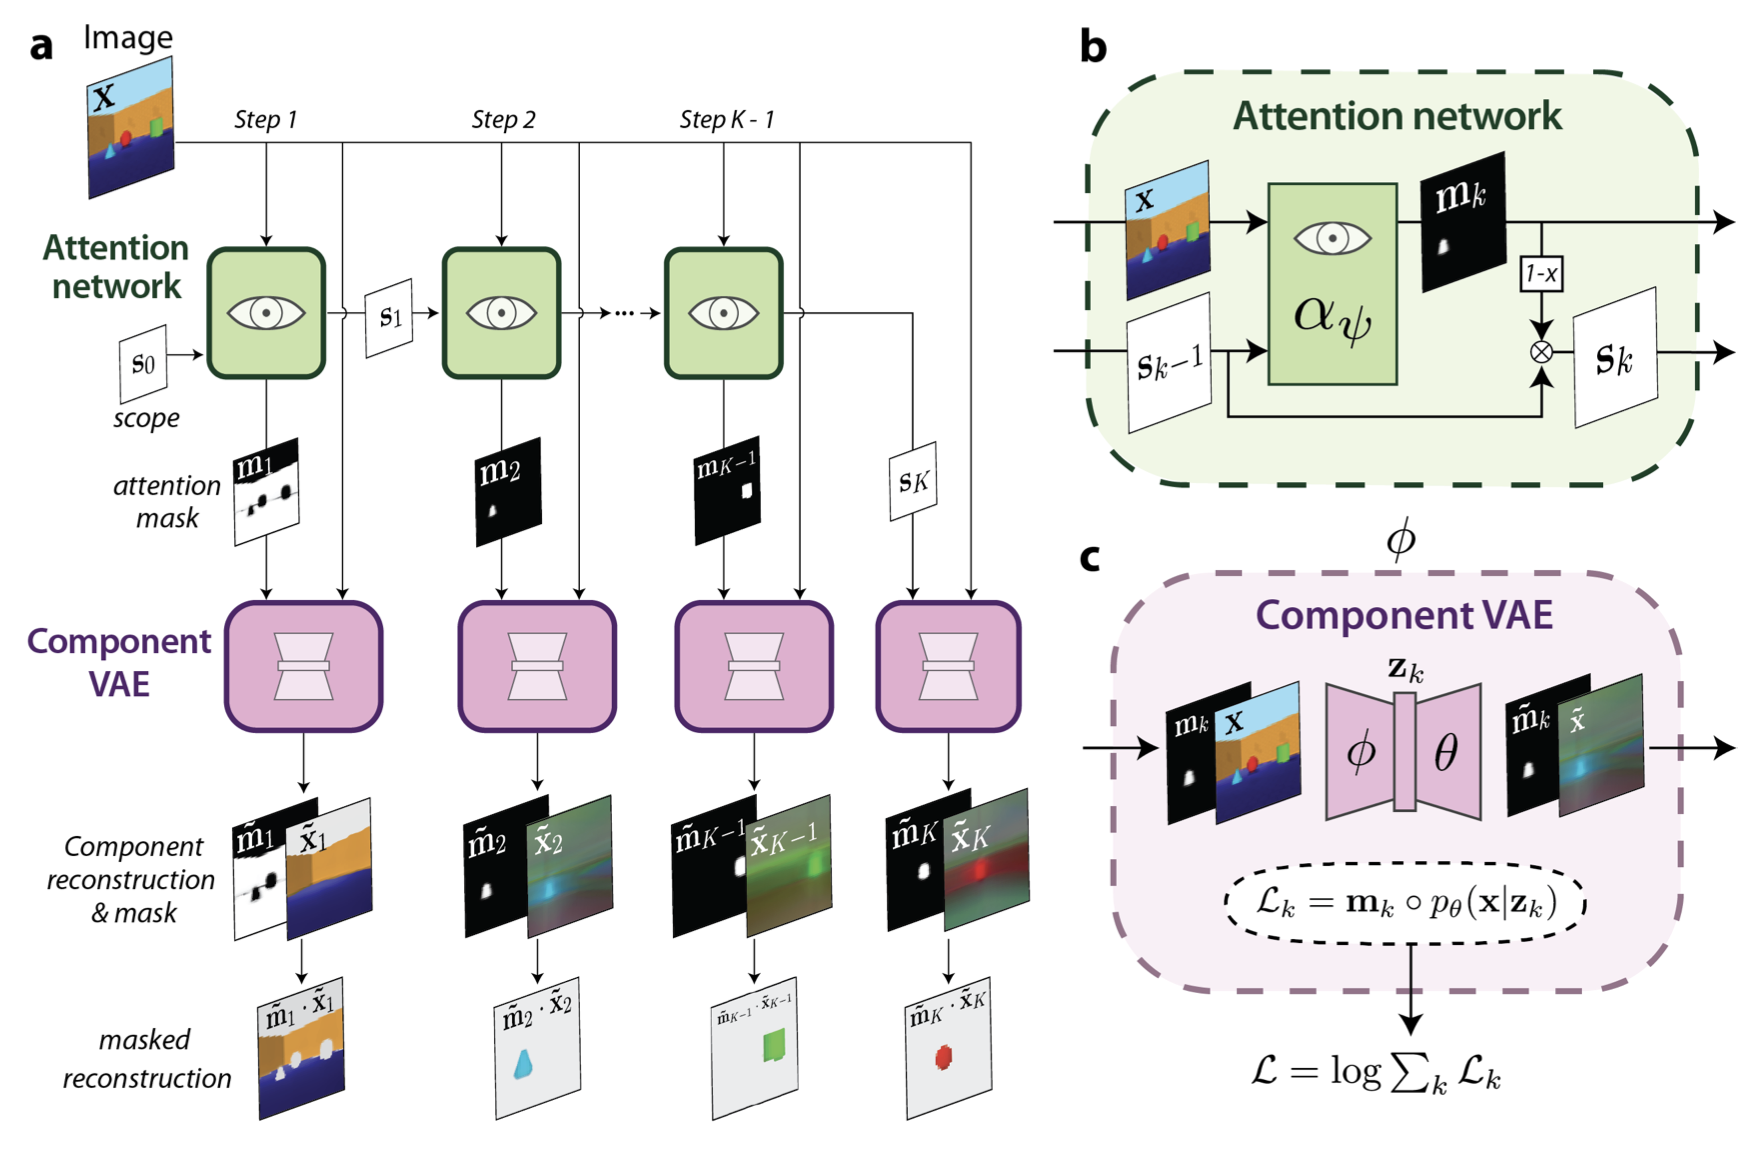

Each component of the network is explained in greater detail below.


### Component: VAE

#### Idea

The idea behind the VAE is to reconstruct each component of the scene independently, but in the same representational medium/substrate. Each reconstructed component is masked so that the contents of the reconstruction outside the original masked region are inconsequential.

#### Interface

The VAE takes as input the image to be decomposed (in three-channel RGB format) alongside a probabilistic 'attention' mask (i.e., a grid of numbers between 0 and 1 spanning each pixel in the image) representing the current focus of the model. So, the encoder of the VAE generates a low-dimensional latent representation from this masked image.

The VAE produces as output a reconstruction of the masked portion of the original input image (again, in three-channel RGB format) alongside a reconstruction of the original input mask. So, the decoder of the VAE reconstructs from this latent representation the masked portion of the image and the mask itself.

#### Implementation

The encoder of the VAE is a deep convolutional neural network (CNN) that compresses the image while extracting high-level features followed by a two-layer multi-layer perceptron (MLP) that transforms this information further. This produces the parameters of a 16-dimensional Gaussian distribution, which is then sampled to form the latent representation. This sampled vector is transformed into an enlarged spatial tiling for subsequent processing.

The decoder of the VAE is also a deep CNN that regenerates the image and mask from the latent representation. The reconstructed image component is itself treated as a probability distribution with means represented by the decoder outputs (and constant standard deviations, explored later), while the reconstructed mask merely represents logits that can be transformed into proper masks by a later softmax operation.

#### Notes

* The image size after each stage of the encoder is not given in the original paper. To keep the dimensions well-behaved, we apply padding to ensure the image size remains a power of 2. Beginning with a 64$\times$64$\times$4 input (image and mask), the representation becomes size 32$\times$32$\times$32, 16$\times$16$\times$32, 8$\times$8$\times$64, and finally 4$\times$4$\times$64 throughout the deep CNN.
* To sample from the latent Gaussian distribution, the reparameterization trick is used (i.e., the fact that $ z \sim \mathcal{N}(\mu, \sigma) $ is equivalent to $ z = \mu + \sigma \epsilon $ where $ \epsilon \sim \mathcal{N}(0, 1) $).
* As in the original paper, the spatial broadcast operation is taken from [Watters et al](https://arxiv.org/abs/1901.07017).
* Conversely, the image size after each stage of the decoder is given. Beginning with a 72$\times$72$\times$18 input (spatial broadcast of 16-dimensional sampled vector, with a tiling of each of the two dimensions), the representation becomes size 70$\times$70$\times$32, 68$\times$68$\times$32, 66$\times$66$\times$32, and finally 64$\times$64$\times$32 throughout the deep CNN before being transformed to the desired 64$\times$64$\times$4 output size.
* The input mask is required to be in logarithmic units. To our understanding, this is done to produce a broader representational range in the NN instead of the narrow range of $[0, 1]$.
* The standard deviations of the pixels in the reconstructed components are handled separately in the greater MONet model, as is the softmax operation that converts the reconstructed masks into a probability distribution.


In [2]:
"""
VAE of the system.
"""
class VAE(nn.Module):
    """
    Creates the VAE, building the encoder and decoder.
    """
    def __init__(self, batch_size):
        super().__init__()

        # Pass along batch size to ensure dimensions are consistent
        self.batch_size = batch_size

        # Encoder of the VAE
        # "It receives the concatenation of the input image x ...
        #     and the attention mask in logarithmic units, log mk as input."
        self.encoder_nn = nn.Sequential(
            # "The VAE encoder is a standard CNN with 3x3 kernels, stride 2, and ReLU activations."
            # "The CNN layers output (32, 32, 64, 64) channels respectively."
            # Layer #1
            nn.Conv2d(              # "convolution"
                in_channels=4,      # "the concatenation of the input image x and the attention mask"
                out_channels=32,    # "32"
                kernel_size=3,      # "3x3 kernels"
                stride=2,           # "stride 2"
                padding=1,          # ASSUMPTION
                bias=True,          # ASSUMPTION
            ),                      # 32*32 output because I=64, K=3, S=2, P=1, floor((64-3+2(1))/2)+1=32
            nn.ReLU(),              # "ReLU activations"
            # Layer #2
            nn.Conv2d(              # "convolution"
                in_channels=32,     # FROM PREVIOUS LAYER
                out_channels=32,    # "32"
                kernel_size=3,      # "3x3 kernels"
                stride=2,           # "stride 2"
                padding=1,          # ASSUMPTION
                bias=True,          # ASSUMPTION
            ),                      # 16*16 output because I=32, K=3, S=2, P=1, floor((32-3+2(1))/2)+1=16
            nn.ReLU(),              # "ReLU activations"
            # Layer #3
            nn.Conv2d(              # "convolution"
                in_channels=32,     # FROM PREVIOUS LAYER
                out_channels=64,    # "64"
                kernel_size=3,      # "3x3 kernels"
                stride=2,           # "stride 2"
                padding=1,          # ASSUMPTION
                bias=True,          # ASSUMPTION
            ),                      # 8*8 output because I=16, K=3, S=2, P=1, floor((16-3+2(1))/2)+1=8
            nn.ReLU(),              # "ReLU activations"
            # Layer #4
            nn.Conv2d(              # "convolution"
                in_channels=64,     # FROM PREVIOUS LAYER
                out_channels=64,    # "64"
                kernel_size=3,      # "3x3 kernels"
                stride=2,           # "stride 2"
                padding=1,          # ASSUMPTION
                bias=True,          # ASSUMPTION
            ),                      # 4*4 output because I=8, K=3, S=2, P=1, floor((8-3+2(1))/2)+1=4
            nn.ReLU(),              # "ReLU activations"
            # "The CNN output is flattened and fed to a 2 layer MLP with output sizes of (256, 32)."
            # "The MLP output parameterises the μ and log σ of a 16-dim Gaussian latent posterior."
            nn.Flatten(),
            nn.Linear(              # "MLP"
                in_features=1024,   # FROM PREVIOUS LAYER
                out_features=256,   # "256"
            ),                      # ASSUMPTION (no activation)
            nn.Linear(              # "MLP"
                in_features=256,    # FROM PREVIOUS LAYER
                out_features=32,    # "32"
            ),                      # ASSUMPTION (no activation)
        )

        # Decoder of the VAE
        self.decoder_nn = nn.Sequential(
            # "The input to the broadcast decoder is a spatial tiling of zk concatenated with ...
            #     a pair of coordinate channels – one for each spatial dimension – ranging from -1 to 1."
            # "These go through a four-layer CNN with no padding, 3x3 kernels, ...
            #     stride 1, 32 output channels and ReLU activations."
            # Layer #1
            nn.Conv2d(              # "convolution"
                in_channels=18,     # "a spatial tiling of zk concatenated with a pair of coordinate channels"
                out_channels=32,    # "32 output channels"
                kernel_size=3,      # "3x3 kernels"
                stride=1,           # "stride 1"
                padding=0,          # "no padding"
                bias=True,          # ASSUMPTION
            ),                      # 70*70 output because I=72, K=3, S=1, P=0, floor((72-3+2(0))/1)+1=70
            nn.ReLU(),              # "ReLU activations"
            # Layer #2
            nn.Conv2d(              # "convolution"
                in_channels=32,     # FROM PREVIOUS LAYER
                out_channels=32,    # "32 output channels"
                kernel_size=3,      # "3x3 kernels"
                stride=1,           # "stride 1"
                padding=0,          # "no padding"
                bias=True,          # ASSUMPTION
            ),                      # 68*68 output because I=70, K=3, S=1, P=0, floor((70-3+2(0))/1)+1=68
            nn.ReLU(),              # "ReLU activations"
            # Layer #3
            nn.Conv2d(              # "convolution"
                in_channels=32,     # FROM PREVIOUS LAYER
                out_channels=32,    # "32 output channels"
                kernel_size=3,      # "3x3 kernels"
                stride=1,           # "stride 1"
                padding=0,          # "no padding"
                bias=True,          # ASSUMPTION
            ),                      # 66*66 output because I=68, K=3, S=1, P=0, floor((68-3+2(0))/1)+1=66
            nn.ReLU(),              # "ReLU activations"
            # Layer #4
            nn.Conv2d(              # "convolution"
                in_channels=32,     # FROM PREVIOUS LAYER
                out_channels=32,    # "32 output channels"
                kernel_size=3,      # "3x3 kernels"
                stride=1,           # "stride 1"
                padding=0,          # "no padding"
                bias=True,          # ASSUMPTION
            ),                      # 64*64 output because I=66, K=3, S=1, P=0, floor((66-3+2(0))/1)+1=64
            nn.ReLU(),              # "ReLU activations"
            # "A final 1x1 convolutional layer transforms the output into 4 channels: ...
            #     3 RGB channels for the means of the image components xˆk, and ...
            #     1 for the logits used for the softmax operation to compute the reconstructed attention masks mˆk."
            nn.Conv2d(              # "convolution"
                in_channels=32,     # FROM PREVIOUS LAYER
                out_channels=4,     # "4 channels"
                kernel_size=1,      # "1x1 convolutional layer"
                stride=1,           # ASSUMPTION
                padding=0,          # ASSUMPTION
                bias=True,          # ASSUMPTION
            ),                      # 64*64 output because I=64, K=1, S=1, P=0, floor((64-1+2(0))/1)+1=64
        )
        return
        
    """
    Uses the encoder of the VAE to generate the latent distribution.
        Inputs: 64*64 RGB image (x), 64*64 logarithmic mask (log_mk)
        Outputs: 16-dimensional Gaussian latent posterior (mu, log_sig)
    """
    def encode(self, x, log_mk):
        # Encode the input into a latent representation
        # "It receives the concatenation of the input image x and ...
        #     the attention mask in logarithmic units, log mk as input."
        latent_repr = self.encoder_nn(torch.concat((x, log_mk), dim=1))
        # assert (len(latent_repr.shape) == 2) and (latent_repr.shape[0] == self.batch_size) and (latent_repr.shape[1] == 32)

        # Convert this latent representation into the probability distribution
        # "The MLP output parameterises the μ and logσ of a 16-dim Gaussian latent posterior."
        mu = torch.split(latent_repr, 16, dim=1)[0]
        log_sig = torch.split(latent_repr, 16, dim=1)[1]
        # assert (len(mu.shape) == 2) and (mu.shape[0] == self.batch_size) and (mu.shape[1] == 16)
        # assert (len(log_sig.shape) == 2) and (log_sig.shape[0] == self.batch_size) and (log_sig.shape[1] == 16)

        # Output of the encoder is the parameters of the probability distribution
        return mu, log_sig
    
    """
    Samples the latent distribution to generate a latent representation.
        Inputs: 16-dimensional Gaussian latent posterior (mu, log_sig)
        Outputs: Sampled latent vector (z)
    """
    def reparameterize(self, mu, log_sig):
        # Sample the represented distribution based on its mean and standard deviation
        std = torch.exp(log_sig)
        eps = torch.randn_like(std)
        z = mu + eps * std
        # assert (len(z.shape) == 2) and (z.shape[0] == self.batch_size) and (z.shape[1] == 16)

        # Output of reparameterization is sampled latent vector
        return z
    
    """
    Uses the decoder of the VAE to reconstruct a component of the image and the mask.
        Inputs: 72*72*18 broadcasted sampled representation
        Outputs: 64*64 RGB reconstructed image component means (x_hat_means), 64*64 reconstructed mask logits (m_hat_logits)
    """
    def decode(self, x):
        # Decode the output from a latent representation
        reconstructed_repr = self.decoder_nn(x)
        # assert (len(reconstructed_repr.shape) == 4) and (reconstructed_repr.shape[0] == self.batch_size) and (reconstructed_repr.shape[1] == 4) and (reconstructed_repr.shape[2] == 64) and (reconstructed_repr.shape[3] == 64)

        # Convert this output into the reconstructed image and mask
        # "3 RGB channels for the means of the image components xˆk, and 1 for the logits ...
        #     used for the softmax operation to compute the reconstructed attention masks mˆk"
        x_hat_means = torch.split(reconstructed_repr, [3, 1], dim=1)[0]
        m_hat_logits = torch.split(reconstructed_repr, [3, 1], dim=1)[1]
        # assert (len(x_hat_means.shape) == 4) and (x_hat_means.shape[0] == self.batch_size) and (x_hat_means.shape[1] == 3) and (x_hat_means.shape[2] == 64) and (x_hat_means.shape[3] == 64)
        # assert (len(m_hat_logits.shape) == 4) and (m_hat_logits.shape[0] == self.batch_size) and (m_hat_logits.shape[1] == 1) and (m_hat_logits.shape[2] == 64) and (m_hat_logits.shape[3] == 64)

        # Output of the decoder is the reconstructed image component means and reconstructed mask logits
        return x_hat_means, m_hat_logits
    
    """
    Performs a full forward pass of the VAE, including both encoding and decoding.
        Inputs: 64*64 RGB image (x), 64*64 logarithmic mask (log_mk)
        Outputs: 16-dimensional Gaussian latent posterior (mu, log_sig), 64*64 RGB reconstructed image ...
            component means (x_hat_means), 64*64 reconstructed mask logits (m_hat_logits)
    """
    def forward(self, x, log_mk):
        # First, encode the data into the latent space
        mu, log_sig = self.encode(x, log_mk)
        # assert (len(mu.shape) == 2) and (mu.shape[0] == self.batch_size) and (mu.shape[1] == 16)
        # assert (len(log_sig.shape) == 2) and (log_sig.shape[0] == self.batch_size) and (log_sig.shape[1] == 16)

        # Second, transform the latent distributions into a sampled image
        # "The input to the broadcast decoder is a spatial tiling of zk ...
        #     concatenated with a pair of coordinate channels - one for ...
        #     each spatial dimension - ranging from -1 to 1."
        z = self.reparameterize(mu, log_sig)
        # assert (len(z.shape) == 2) and (z.shape[0] == self.batch_size) and (z.shape[1] == 16)
        z = z.reshape((self.batch_size, 16, 1, 1)).repeat((1, 1, 72, 72))
        # assert (len(z.shape) == 4) and (z.shape[0] == self.batch_size) and (z.shape[1] == 16) and (z.shape[2] == 72) and (z.shape[3] == 72)
        dim1 = torch.linspace(-1, 1, 72, device=device)
        dim2 = torch.linspace(-1, 1, 72, device=device)
        dim1, dim2 = torch.meshgrid(dim1, dim2, indexing="ij")
        dim1 = dim1.reshape((1, 1, 72, 72)).repeat((self.batch_size, 1, 1, 1))
        dim2 = dim2.reshape((1, 1, 72, 72)).repeat((self.batch_size, 1, 1, 1))
        # assert (len(dim1.shape) == 4) and (dim1.shape[0] == self.batch_size) and (dim1.shape[1] == 1) and (dim1.shape[2] == 72) and (dim1.shape[3] == 72)
        # assert (len(dim2.shape) == 4) and (dim2.shape[0] == self.batch_size) and (dim2.shape[1] == 1) and (dim2.shape[2] == 72) and (dim2.shape[3] == 72)

        # Third, decode the data from the latent space
        x_hat_means, m_hat_logits = self.decode(torch.concat((z, dim1, dim2), dim=1))
        # assert (len(x_hat_means.shape) == 4) and (x_hat_means.shape[0] == self.batch_size) and (x_hat_means.shape[1] == 3) and (x_hat_means.shape[2] == 64) and (x_hat_means.shape[3] == 64)
        # assert (len(m_hat_logits.shape) == 4) and (m_hat_logits.shape[0] == self.batch_size) and (m_hat_logits.shape[1] == 1) and (m_hat_logits.shape[2] == 64) and (m_hat_logits.shape[3] == 64)

        # Output of the overall VAE is the parameters of the probability distribution and the reconstructed image and mask
        return mu, log_sig, x_hat_means, m_hat_logits


### Component: Attention

#### Idea

The idea behind the attention network (which is a misnomer; this network has nothing to do wth transformer attention) is to generate a set of masks that decompose the image into a separate component for each object. The masks must be probabilistic (i.e., each pixel value in every mask must be between 0 and 1 and the values of every pixels across each mask must sum to 1), representing the chance that that pixel is part of the object present in the mask (so they should be close to 0 or close to 1). To enforce this, the attention network is invoked recurrently.

#### Interface

The attention network takes as input the image to be decomposed (in three-channel RGB format) alongside a probabilistic active scope (i.e., a grid of numbers between 0 and 1 spanning each pixel in the image) representing the portions of the image that remain to be explained (i.e., what objects must still be masked). This scope is the recurrent state that is tracked in the greater MONet model.

The attention network produces as output a new mask representing the next object in the image to focus on alongside an updated version of the remaining active scope. The scope is updated such that the new scope is the same as the old scope, except with the regions accounted for by the new mask removed.

#### Implementation

The attention network itself is a deep CNN with a U-Net structure, introduced by [Ronneberger et al](https://arxiv.org/abs/1505.04597). The network builds successively larger feature maps while compressing the image along the downsampling path and reconstructs an image-like representation while condensing feature maps along the upsampling path. These paths are joined by a large MLP non-skip connection and several direct skip connections.

The computation to generate the mask, $m_k$, and update the scope, $s_k$, based on the output of the attention network (after the application of a sigmoid function), $\alpha_k$, is given in the original paper as:

$$ m_k = s_{k-1} \alpha_k $$
$$ s_k = s_{k-1} (1 - \alpha_k) $$

The values are maintained in logarithmic units, so applying the laws of logarithms produces:

$$ \log{m_k} = \log{s_{k-1}} + \log{\alpha_k} $$
$$ \log{s_k} = \log{s_{k-1}} + \log{(1 - \alpha_k)} = \log{s_{k-1}} + \log{\alpha_k} - a_k $$

where $a_k$ represents the output of the attention network before the application of the sigmoid function (because $ \log{(1 - \alpha_k)} = \log{(1 - \frac{1}{1+e^{-a_k}})} = \log{\frac{e^{-a_k}}{1+e^{-a_k}}} = \log{\frac{1}{1+e^{-a_k}}} - \log{e^{a_k}} = \log{\frac{1}{1+e^{-a_k}}} - a_k = \log{\alpha_k} - a_k $). This non-obvious simplification was made more clear by consulting [a third-party implementation of the model](https://github.com/baudm/MONet-pytorch). These are the computation and update rule that are implemented directly in the code.

#### Notes

* The number of channels after each step in the U-Net is not given in the original paper. We assumed a standard structure of doubling along the downsampling path and halving along the upsampling path (although it appears to be quartering, the size of the input is first doubled due to the skip connection, so this operation actually represents halving).
* The image size after each step is also not given in the original paper. To keep the dimensions well-behaved, we apply padding to ensure the image size remains a power of 2.
* Combining these two assumptions, we get reasonable dimensions throughout the model. The network begins with a 64$\times$64$\times$4 input (image and current active scope) and the representation goes through sizes of 32$\times$32$\times$8, 16$\times$16$\times$16, 8$\times$8$\times$32, 4$\times$4$\times$64, and 4$\times$4$\times$128 on the downsampling path. On the upsampling path, the input is 4$\times$4$\times$256 (because of the concatenation of the skip and nonskip connections) and the representation goes through sizes of 8$\times$8$\times$128, 16$\times$16$\times$64, 32$\times$32$\times$32, 64$\times$64$\times$16, and finally results in a 64$\times$64$\times$1 output (the number of channels throughout is doubled because of the skip connections).
* PyTorch does not have a direct downsampling operation (at least we could not find one). To perform downsampling, we use average pooling, which we believe is essentially the same operation. A direct upsampling operation does exist, however, so we use that.
* The skip connections are not actually connections in the network. Instead, we implement them as concatenations of intermediate variables along the forward pass of the model.
* To use the MLP of the non-skip connection, we perform flattening and reshaping operations; these do not affect the contents of the data but merely the way the data is presented, so it poses no issues to the representational integrity of the model.
* As required for the VAE, the mask is generated in logarithmic units. Again, this is done to produce a broader representational range in the NN instead of the narrow range of $[0, 1]$ (to our understanding).
* The scope is also maintained in logarithmic units, for the same reason.


In [3]:
"""
Attention network of the system.
"""
class Attention(nn.Module):
    """
    Creates the attention network, building the downwards and upwards paths of the UNet.
    """
    def __init__(self, batch_size):
        super().__init__()
        
        # Pass along batch size to ensure dimensions are consistent
        self.batch_size = batch_size

        # Downsampling path of the U-Net
        # "We used a standard U-Net blueprint with five blocks each on the downsampling and upsampling paths."
        # "At the kth attention step, the attention network receives the concatenation of the input image x ...
        #     and the current scope mask in log units, logsk, as input."
        # "Each block consists of the following: a 3x3 bias-free convolution with stride 1, ...
        #     followed by instance normalisation with a learned bias term, followed by ...
        #     a ReLU activation, and finally downsampled or upsampled by a factor of 2 using ...
        #     nearest neighbour-resizing (no resizing occurs in the last block of each path)."
        # Block #1
        self.down_nn_1 = nn.Sequential(
            nn.Conv2d(              # "convolution"
                in_channels=4,      # "the concatenation of the input image x and the current scope mask"
                out_channels=8,     # ASSUMPTION
                kernel_size=3,      # "3x3 bias-free convolution"
                stride=1,           # "stride 1"
                padding=1,          # ASSUMPTION
                bias=False,         # "bias-free"
            ),                      # 64*64 output because I=64, K=3, S=1, P=1, floor((64-3+2(1))/1)+1=64
            nn.InstanceNorm2d(      # "instance normalisation"
                num_features=8,     # FROM PREVIOUS LAYER
                affine=True,        # "with a learned bias term"
            ),                      # 64*64 output maintained
            nn.ReLU(),              # "ReLU activation"
        )
        self.down_sample_1 = nn.Sequential(
            nn.AvgPool2d(           # "and finally downsampled or upsampled"
                kernel_size=2,      # "by a factor of 2"
                stride=2,           # "by a factor of 2"
                padding=0,          # ASSUMPTION
                ceil_mode=True,     # ASSUMPTION
            ),                      # 32*32 output because I=64, K=2, S=2, P=0, ceil((64-2+2(0))/2)+1=32
        )
        # Block #2
        self.down_nn_2 = nn.Sequential(
            nn.Conv2d(              # "convolution"
                in_channels=8,      # FROM PREVIOUS LAYER
                out_channels=16,    # ASSUMPTION
                kernel_size=3,      # "3x3 bias-free convolution"
                stride=1,           # "stride 1"
                padding=1,          # ASSUMPTION
                bias=False,         # "bias-free"
            ),                      # 32*32 output because I=32, K=3, S=1, P=1, floor((32-3+2(1))/1)+1=32
            nn.InstanceNorm2d(      # "instance normalisation"
                num_features=16,    # FROM PREVIOUS LAYER
                affine=True,        # "with a learned bias term"
            ),                      # 32*32 output maintained
            nn.ReLU(),              # "ReLU activation"
        )
        self.down_sample_2 = nn.Sequential(
            nn.AvgPool2d(           # "and finally downsampled or upsampled"
                kernel_size=2,      # "by a factor of 2"
                stride=2,           # "by a factor of 2"
                padding=0,          # ASSUMPTION
                ceil_mode=True,     # ASSUMPTION
            ),                      # 16*16 output because I=29, K=2, S=2, P=0, ceil((32-2+2(0))/2)+1=16
        )
        # Block #3
        self.down_nn_3 = nn.Sequential(
            nn.Conv2d(              # "convolution"
                in_channels=16,     # FROM PREVIOUS LAYER
                out_channels=32,    # ASSUMPTION
                kernel_size=3,      # "3x3 bias-free convolution"
                stride=1,           # "stride 1"
                padding=1,          # ASSUMPTION
                bias=False,         # "bias-free"
            ),                      # 16*16 output because I=16, K=3, S=1, P=1, floor((16-3+2(1))/1)+1=16
            nn.InstanceNorm2d(      # "instance normalisation"
                num_features=32,    # FROM PREVIOUS LAYER
                affine=True,        # "with a learned bias term"
            ),                      # 16*16 output maintained
            nn.ReLU(),              # "ReLU activation"
        )
        self.down_sample_3 = nn.Sequential(
            nn.AvgPool2d(           # "and finally downsampled or upsampled"
                kernel_size=2,      # "by a factor of 2"
                stride=2,           # "by a factor of 2"
                padding=0,          # ASSUMPTION
                ceil_mode=True,     # ASSUMPTION
            ),                      # 8*8 output because I=16, K=2, S=2, P=0, ceil((16-2+2(0))/2)+1=8
        )
        # Block #4
        self.down_nn_4 = nn.Sequential(
            nn.Conv2d(              # "convolution"
                in_channels=32,     # FROM PREVIOUS LAYER
                out_channels=64,    # ASSUMPTION
                kernel_size=3,      # "3x3 bias-free convolution"
                stride=1,           # "stride 1"
                padding=1,          # ASSUMPTION
                bias=False,         # "bias-free"
            ),                      # 8*8 output because I=8, K=3, S=1, P=1, floor((8-3+2(1))/1)+1=8
            nn.InstanceNorm2d(      # "instance normalisation"
                num_features=64,    # FROM PREVIOUS LAYER
                affine=True,        # "with a learned bias term"
            ),                      # 8*8 output maintained
            nn.ReLU(),              # "ReLU activation"
        )
        self.down_sample_4 = nn.Sequential(
            nn.AvgPool2d(           # "and finally downsampled or upsampled"
                kernel_size=2,      # "by a factor of 2"
                stride=2,           # "by a factor of 2"
                padding=0,          # ASSUMPTION
                ceil_mode=True,     # ASSUMPTION
            ),                      # 4*4 output because I=5, K=2, S=2, P=0, ceil((8-2+2(0))/2)+1=4
        )
        # Block #5
        self.down_nn_5 = nn.Sequential(
            nn.Conv2d(              # "convolution"
                in_channels=64,     # FROM PREVIOUS LAYER
                out_channels=128,   # ASSUMPTION
                kernel_size=3,      # "3x3 bias-free convolution"
                stride=1,           # "stride 1"
                padding=1,          # ASSUMPTION
                bias=False,         # "bias-free"
            ),                      # 4*4 output because I=4, K=3, S=1, P=1, floor((4-3+2(1))/1)+1=4
            nn.InstanceNorm2d(      # "instance normalisation"
                num_features=128,   # FROM PREVIOUS LAYER
                affine=True,        # "with a learned bias term"
            ),                      # 4*4 output maintained
            nn.ReLU(),              # "ReLU activation"
            # "no resizing occurs in the last block of each path"
        )

        # Skip connections of the UNet
        # "Skip tensors are collected from each block in the downsampling path ...
        #     after the ReLU activation function. These are concatenated with input ...
        #     tensors along the upsampling blocks before the convolutional layer."
        self.skip_nn = nn.Sequential(
            # Implemented in forward() function
            None,
        )

        # Nonskip connections of the UNet
        # # "A 3-layer MLP serves as the non-skip connection between the downsampling and ...
        #     upsampling paths with its final output dimensionally matching that of the ...
        #     last skip tensor.""
        self.middle_nn = nn.Sequential(
            # "The intermediate hidden layers were sized (128, 128). The input to the MLP is ...
            #     the last skip tensor collected from the downsampling path (after flattening). ...
            #     A ReLU activation is applied after all three output layers. The final output is ...
            #     then reshaped to match that of the last skip tensor, concatenated with it, ...
            #     and finally fed into the upsampling path."
            nn.Flatten(),
            # Layer #1
            nn.Linear(              # "MLP"
                in_features=2048,   # FROM PREVIOUS LAYER
                out_features=128,   # "128"
            ),
            nn.ReLU(),              # "ReLU activation"
            # Layer #2
            nn.Linear(              # "MLP"
                in_features=128,    # FROM PREVIOUS LAYER
                out_features=128,   # "128"
            ),
            nn.ReLU(),              # "ReLU activation"
            # Layer #3
            nn.Linear(              # "MLP"
                in_features=128,    # FROM PREVIOUS LAYER
                out_features=2048,  # "reshaped to match that of the last skip tensor"
            ),
            nn.ReLU(),              # "ReLU activation"
        )

        # "We used a standard U-Net blueprint with five blocks each on the downsampling and upsampling paths."
        # "Each block consists of the following: a 3x3 bias-free convolution with stride 1, ...
        #     followed by instance normalisation with a learned bias term, followed by ...
        #     a ReLU activation, and finally downsampled or upsampled by a factor of 2 using ...
        #     nearest neighbour-resizing (no resizing occurs in the last block of each path)."
        # Block #1
        self.up_nn_1 = nn.Sequential(
            nn.Conv2d(              # "convolution"
                in_channels=256,    # FROM PREVIOUS LAYER
                out_channels=64,    # ASSUMPTION
                kernel_size=3,      # "3x3 bias-free convolution"
                stride=1,           # "stride 1"
                padding=1,          # ASSUMPTION
                bias=False,         # "bias-free"
            ),                      # 4*4 output because I=4, K=3, S=1, P=1, floor((4-3+2(1))/1)+1=4
            nn.InstanceNorm2d(      # "instance normalisation"
                num_features=64,    # FROM PREVIOUS LAYER
                affine=True,        # "with a learned bias term"
            ),                      # 4*4 output maintained
            nn.ReLU(),              # "ReLU activation"
            nn.Upsample(            # "and finally downsampled or upsampled"
                scale_factor=2,     # "by a factor of 2"
                mode="nearest",     # "using nearest neighbour-resizing"
            ),
        )
        # Block #2
        self.up_nn_2 = nn.Sequential(
            nn.Conv2d(              # "convolution"
                in_channels=128,    # FROM PREVIOUS LAYER
                out_channels=32,    # ASSUMPTION
                kernel_size=3,      # "3x3 bias-free convolution"
                stride=1,           # "stride 1"
                padding=1,          # ASSUMPTION
                bias=False,         # "bias-free"
            ),                      # 8*8 output because I=8, K=3, S=1, P=1, floor((8-3+2(1))/1)+1=8
            nn.InstanceNorm2d(      # "instance normalisation"
                num_features=32,    # FROM PREVIOUS LAYER
                affine=True,        # "with a learned bias term"
            ),                      # 8*8 output maintained
            nn.ReLU(),              # "ReLU activation"
            nn.Upsample(            # "and finally downsampled or upsampled"
                scale_factor=2,     # "by a factor of 2"
                mode="nearest",     # "using nearest neighbour-resizing"
            ),
        )
        # Block #3
        self.up_nn_3 = nn.Sequential(
            nn.Conv2d(              # "convolution"
                in_channels=64,     # FROM PREVIOUS LAYER
                out_channels=16,    # ASSUMPTION
                kernel_size=3,      # "3x3 bias-free convolution"
                stride=1,           # "stride 1"
                padding=1,          # ASSUMPTION
                bias=False,         # "bias-free"
            ),                      # 16*16 output because I=16, K=3, S=1, P=1, floor((16-3+2(1))/1)+1=16
            nn.InstanceNorm2d(      # "instance normalisation"
                num_features=16,    # FROM PREVIOUS LAYER
                affine=True,        # "with a learned bias term"
            ),                      # 16*16 output maintained
            nn.ReLU(),              # "ReLU activation"
            nn.Upsample(            # "and finally downsampled or upsampled"
                scale_factor=2,     # "by a factor of 2"
                mode="nearest",     # "using nearest neighbour-resizing"
            ),
        )
        # Block #4
        self.up_nn_4 = nn.Sequential(
            nn.Conv2d(              # "convolution"
                in_channels=32,     # FROM PREVIOUS LAYER
                out_channels=8,     # ASSUMPTION
                kernel_size=3,      # "3x3 bias-free convolution"
                stride=1,           # "stride 1"
                padding=1,          # ASSUMPTION
                bias=False,         # "bias-free"
            ),                      # 32*32 output because I=32, K=3, S=1, P=1, floor((32-3+2(1))/1)+1=32
            nn.InstanceNorm2d(      # "instance normalisation"
                num_features=8,     # FROM PREVIOUS LAYER
                affine=True,        # "with a learned bias term"
            ),                      # 32*32 output maintained
            nn.ReLU(),              # "ReLU activation"
            nn.Upsample(            # "and finally downsampled or upsampled"
                scale_factor=2,     # "by a factor of 2"
                mode="nearest",     # "using nearest neighbour-resizing"
            ),
        )
        # Block #5
        self.up_nn_5 = nn.Sequential(
            nn.Conv2d(              # "convolution"
                in_channels=16,     # FROM PREVIOUS LAYER
                out_channels=4,     # ASSUMPTION
                kernel_size=3,      # "3x3 bias-free convolution"
                stride=1,           # "stride 1"
                padding=1,          # ASSUMPTION
                bias=False,         # "bias-free"
            ),                      # 64*64 output because I=64, K=3, S=1, P=1, floor((64-3+2(1))/1)+1=64
            nn.InstanceNorm2d(      # "instance normalisation"
                num_features=4,     # FROM PREVIOUS LAYER
                affine=True,        # "with a learned bias term"
            ),                      # 64*64 output maintained
            nn.ReLU(),              # "ReLU activation"
            # "no resizing occurs in the last block of each path"
        )

        # "Following the upsampling path, a final 1x1 convolution with stride 1 ...
        #     and a single output channel transforms the U-Net output into the ...
        #     logits for αk. Both log αk and log(1 − αk) are computed directly in ...
        #     log units from the logits (using the log softmax operation). Each are ...
        #     added to the current scope (also maintained in log units) log sk−1 to ...
        #     compute the next (log) attention mask log mk and next (log) scope log sk, respectively.""
        self.final_nn = nn.Sequential(
            nn.Conv2d(              # "convolution"
                in_channels=4,      # FROM PREVIOUS LAYER
                out_channels=1,     # "a single output channel"
                kernel_size=1,      # "1x1 convolution"
                stride=1,           # "stride 1"
                padding=0,          # ASSUMPTION
                bias=True,          # ASSUMPTION
            ),                      # 64*64 output because I=64, K=1, S=1, P=0, floor((64-1+2(0))/1)+1=64
        )
        return
    
    """
    Performs a full forward pass of the attention network, updating internal state.
        Inputs: 64*64 RGB image (x), current logarithmic scope (log_sk)
        Outputs: 64*64 logarithmic mask (log_mk), next logarithmic scope (log_skp1)
    """
    def forward(self, x, log_sk):
        # First, downsample the data down the "U" of the UNet
        x1 = self.down_nn_1(torch.concat((x, log_sk), dim=1))
        # assert (len(x1.shape) == 4) and (x1.shape[0] == self.batch_size) and (x1.shape[1] == 8) and (x1.shape[2] == 64) and (x1.shape[3] == 64)
        x2 = self.down_nn_2(self.down_sample_1(x1))
        # assert (len(x2.shape) == 4) and (x2.shape[0] == self.batch_size) and (x2.shape[1] == 16) and (x2.shape[2] == 32) and (x2.shape[3] == 32)
        x3 = self.down_nn_3(self.down_sample_2(x2))
        # assert (len(x3.shape) == 4) and (x3.shape[0] == self.batch_size) and (x3.shape[1] == 32) and (x3.shape[2] == 16) and (x3.shape[3] == 16)
        x4 = self.down_nn_4(self.down_sample_3(x3))
        # assert (len(x4.shape) == 4) and (x4.shape[0] == self.batch_size) and (x4.shape[1] == 64) and (x4.shape[2] == 8) and (x4.shape[3] == 8)
        x5 = self.down_nn_5(self.down_sample_4(x4))
        # assert (len(x5.shape) == 4) and (x5.shape[0] == self.batch_size) and (x5.shape[1] == 128) and (x5.shape[2] == 4) and (x5.shape[3] == 4)

        # Second, compute the nonskip connection at the bottom of the "U" of the UNet
        y0 = self.middle_nn(x5).reshape((self.batch_size, 128, 4, 4))
        # assert (len(y0.shape) == 4) and (y0.shape[0] == self.batch_size) and (y0.shape[1] == 128) and (y0.shape[2] == 4) and (y0.shape[3] == 4)

        # Third, upsample the data up the "U" of the UNet
        # Successively call upsampling networks on processed data
        # Apply skip connections by concatenating previous data to the current data
        y1 = self.up_nn_1(torch.concat((y0, x5), dim=1))
        # assert (len(y1.shape) == 4) and (y1.shape[0] == self.batch_size) and (y1.shape[1] == 64) and (y1.shape[2] == 8) and (y1.shape[3] == 8)
        y2 = self.up_nn_2(torch.concat((y1, x4), dim=1))
        # assert (len(y2.shape) == 4) and (y2.shape[0] == self.batch_size) and (y2.shape[1] == 32) and (y2.shape[2] == 16) and (y2.shape[3] == 16)
        y3 = self.up_nn_3(torch.concat((y2, x3), dim=1))
        # assert (len(y3.shape) == 4) and (y3.shape[0] == self.batch_size) and (y3.shape[1] == 16) and (y3.shape[2] == 32) and (y3.shape[3] == 32)
        y4 = self.up_nn_4(torch.concat((y3, x2), dim=1))
        # assert (len(y4.shape) == 4) and (y4.shape[0] == self.batch_size) and (y4.shape[1] == 8) and (y4.shape[2] == 64) and (y4.shape[3] == 64)
        y5 = self.up_nn_5(torch.concat((y4, x1), dim=1))
        # assert (len(y5.shape) == 4) and (y5.shape[0] == self.batch_size) and (y5.shape[1] == 4) and (y5.shape[2] == 64) and (y5.shape[3] == 64)

        # Fourth, compute the output processing at the end of the UNet
        y = self.final_nn(y5)
        # assert (len(y.shape) == 4) and (y.shape[0] == self.batch_size) and (y.shape[1] == 1) and (y.shape[2] == 64) and (y.shape[3] == 64)
        log_alpha = nn.LogSigmoid()(y)
        # assert (len(log_alpha.shape) == 4) and (log_alpha.shape[0] == self.batch_size) and (log_alpha.shape[1] == 1) and (log_alpha.shape[2] == 64) and (log_alpha.shape[3] == 64)

        # Fifth, translate the network output to the desired format
        # "The attention mask for step k is given by mk = sk−1αψ(x;sk−1)"
        log_mk = log_sk + log_alpha
        # assert (len(log_mk.shape) == 4) and (log_mk.shape[0] == self.batch_size) and (log_mk.shape[1] == 1) and (log_mk.shape[2] == 64) and (log_mk.shape[3] == 64)
        # "The scope for the next step is given by sk+1 = sk(1−αψ(x;sk))"
        log_skp1 = log_sk + log_alpha - y
        # assert (len(log_skp1.shape) == 4) and (log_skp1.shape[0] == self.batch_size) and (log_skp1.shape[1] == 1) and (log_skp1.shape[2] == 64) and (log_skp1.shape[3] == 64)

        # Output of the attention network is the mask at the current time step
        return log_mk, log_skp1


### Combination: MONet

#### Idea

The idea behind the MONet is to combine the VAE and attention network to recurrently generate masks that decompose the input image while reconstructing each masked region with a probabilistic bottleneck to keep the masks and reconstructions simple (i.e., disentangled). The number of components/slots, $K$, is a hyperparameter that must be set in advance. 

#### Interface

MONet takes as input only the image to be decomposed (in three-channel RGB format). No other information is required, even during training.

MONet produces as output $K$ attention masks with $K$ image component reconstructions and $K$ reconstructions of these masks. The reconstructed components can be masked and summed to (ideally) reconstruct the input image exactly.

#### Implementation

MONet is implemented as a network containing both components that calls them each in an iterative fashion. The model calls the attention network $K-1$ times to generate $K-1$ attention masks, with the final mask being the leftover scope remaining to be explained. The VAE is invoked independently for each of these $K$ masks. All data is tracked throughout for the purposes of whole image reconstruction.

#### Notes

* The weights of each loss term (described later) were kept the same as in the original paper; given the extreme computational demands of the model, hyperparameter tuning was not feasible.
* Although not required for inference, the parameters of each latent representation generated is tracked and returned because it is required to compute the loss function.


In [4]:
"""
Overall MONet model.
"""
class MONet(nn.Module):
    """
    Creates MONet, building the VAE and attention network.
    """
    def __init__(self, num_slots, batch_size, learning_rate):
        super().__init__()

        # Model general hyperparameters
        # "We used RMSProp for optimisation with a learning rate of 0.0001, and a batch size of 64."
        self.batch_size = batch_size             # "a batch size of 64"
        self.learning_rate = learning_rate       # "a learning rate of 0.0001"

        # Model construction hyperparameters
        # "We trained MONet with K=7 slots."
        self.K = num_slots    # "K=7 slots"
        # "The loss weights were β = 0.5, γ = 0.5."
        self.alpha = 1
        self.beta = 0.5       # "β = 0.5"
        self.gamma = 0.5      # "γ = 0.5"
        # "For the MONet experiments, the first "background" component scale was ...
        #     fixed at σbg = 0.09, and for the K − 1 remaining "foreground" components, ...
        #     the scale was fixed at σfg = 0.11.
        self.sigma_bg = 0.09    # "σbg = 0.09"
        self.sigma_fg = 0.11    # "σfg = 0.11"

        # Model loss
        # First term represents the VAE image reconstruction loss (drives the decoder to properly reconstruct masked region)
        self.loss_1 = None
        # Second term represents the regularization of the VAE (drives the encoder to generate a normal distribution) weighted by beta
        self.loss_2 = None
        # Third term represents the VAE mask reconstruction loss (drives the decoder and encoer to generate proper masks) weighted by gamma
        self.loss_3 = None
        # Overall loss combines all these three terms
        self.loss = None

        # VAE of the model
        # "The component VAE is a neural network, with an encoder parameterised by φ and a decoder parameterised by θ."
        self.vae = VAE(self.batch_size)

        # Attention network of the model
        # "The mask distribution is learned by the attention module, a neural network conditioned on x and parameterised by ψ."
        self.attention = Attention(self.batch_size)

        # Model optimizer
        # "We used RMSProp for optimisation with a learning rate of 0.0001, and a batch size of 64."
        self.optimizer = torch.optim.RMSprop(
            self.parameters(),
            lr=self.learning_rate,
        )
        return

    """
    Performs a full forward pass of MONet, utilizing multiple passes of the VAE and attention network.
        Inputs: 64*64 RGB image (x)
        Outputs: 16-dimensional Gaussian latent posteriors (mus, log_sigs), 64*64 logarithmic masks (log_masks), ...
            64*64 RGB reconstructed image components means (x_hat_means), 64*64 reconstructed masks logits (m_hat_logits)
    """
    def forward(self, x):
        # The parameters of the latent distributions generated by the VAE
        mus = torch.zeros((self.K, self.batch_size, 16), device=device)
        log_sigs = torch.zeros((self.K, self.batch_size, 16), device=device)
        # The masks recurrently generated by the attention network
        log_masks = torch.zeros((self.K, self.batch_size, 1, 64, 64), device=device)
        # The current state of the model
        # Initialize recurrent state variable "with the first scope s0 = 1"
        log_states = torch.zeros((self.K, self.batch_size, 1, 64, 64), device=device)
        log_states[0] = torch.log(torch.ones((self.batch_size, 1, 64, 64), device=device))
        # The region of the image corresponding to the mask as reconstructed by the VAE
        recon_comp_means = torch.zeros((self.K, self.batch_size, 3, 64, 64), device=device)
        # The corresponding masks reconstructed by the VAE
        recon_mask_logits = torch.zeros((self.K, self.batch_size, 1, 64, 64), device=device)

        # Perform normal steps 1, ..., K-1
        for k in range(self.K - 1):
            # Mask k is simply the output of the attention network based on the image (and its current internal state)
            log_masks[k], log_states[k+1] = self.attention(x, log_states[k])
            # Component and mask reconstruction k is the output of the VAE based on the image and desired attention mask
            mus[k], log_sigs[k], recon_comp_means[k], recon_mask_logits[k] = self.vae(x, log_masks[k])
        # Perform final step K, which is different
        # Mask K is the remaining scope to be explained, extracted directly from the attention network
        log_masks[self.K-1] = log_states[self.K-1]
        # Component and mask reconstruction K is still the normal output of the VAE
        mus[self.K-1], log_sigs[self.K-1], recon_comp_means[self.K-1], recon_mask_logits[self.K-1] = self.vae(x, log_masks[self.K-1])

        # assert (len(mus.shape) == 3) and (mus.shape[0] == self.K) and (mus.shape[1] == self.batch_size) and (mus.shape[2] == 16)
        # assert (len(log_sigs.shape) == 3) and (log_sigs.shape[0] == self.K) and (log_sigs.shape[1] == self.batch_size) and (log_sigs.shape[2] == 16)
        # assert (len(log_masks.shape) == 5) and (log_masks.shape[0] == self.K) and (log_masks.shape[1] == self.batch_size) and (log_masks.shape[2] == 1) and (log_masks.shape[3] == 64) and (log_masks.shape[4] == 64)
        # assert (len(log_states.shape) == 5) and (log_states.shape[0] == self.K) and (log_states.shape[1] == self.batch_size) and (log_states.shape[2] == 1) and (log_states.shape[3] == 64) and (log_states.shape[4] == 64)
        # assert (len(recon_comp_means.shape) == 5) and (recon_comp_means.shape[0] == self.K) and (recon_comp_means.shape[1] == self.batch_size) and (recon_comp_means.shape[2] == 3) and (recon_comp_means.shape[3] == 64) and (recon_comp_means.shape[4] == 64)
        # assert (len(recon_mask_logits.shape) == 5) and (recon_mask_logits.shape[0] == self.K) and (recon_mask_logits.shape[1] == self.batch_size) and (recon_mask_logits.shape[2] == 1) and (recon_mask_logits.shape[3] == 64) and (recon_mask_logits.shape[4] == 64)
        masks_sum = torch.sum(log_masks.exp()) / self.batch_size / 64 / 64
        if (masks_sum < 0.99) or (masks_sum > 1.01):
            print(f"WARNING: Mask distributions do not sum to 1. Computed value: {masks_sum}")

        # Output of MONet is the parameters of the probability distribution, mask, and reconstructed image and mask at the current time step
        return mus, log_sigs, log_masks, recon_comp_means, recon_mask_logits


### Training: Loss Function

The original paper defines the loss function as:

$$ \mathcal{L} = -\log{\sum_{k=1}^{K}{m_k p_{\theta}(x \mid z_k)}} + \beta D_{KL}(\prod_{k=1}^{K}{q_{\phi}(z_k \mid x, m_k) \mid \mid p(z)}) + \gamma D_{KL}(q_{\psi}(c \mid x) \mid \mid p_{\theta}(c \mid \{z_k\})) $$

We generalize this construction and simplify each term separately:

$$ \mathcal{L} = \alpha l_1 + \beta l_2 + \gamma l_3 $$

The network is trained end-to-end on this single combined loss function.

#### Loss Term 1

The first term, $l_1$, corresponds to the VAE reconstruction loss:

$ l_1 = -\log{\sum_{k=1}^{K}{m_k p_{\theta}(x \mid z_k)}} $

$ = -\log{\sum_{k=1}^{K}{m_k \frac{1}{\sqrt{2 \pi \sigma_k^2}} e^{-\frac{(x - \mu_k)^2}{2 \sigma_k^2}}}} $ because each pixel is interpreted as a Gaussian

$ = -\log{\frac{1}{\sqrt{2 \pi}} \sum_{k=1}^{K}{\frac{m_k}{\sigma_k} e^{-\frac{(x - \mu_k)^2}{2 \sigma_k^2}}}} = -\log{\frac{1}{\sqrt{2 \pi}}} - \log{\sum_{k=1}^{K}{\frac{m_k}{\sigma_k} e^{-\frac{(x - \mu_k)^2}{2 \sigma_k^2}}}} $ but a constant term in the loss is irrelevant

$ = -\log{\sum_{k=1}^{K}{e^{\log{\frac{m_k}{\sigma_k} e^{-\frac{(x - \mu_k)^2}{2 \sigma_k^2}}}}}} = -\log{\sum_{k=1}^{K}{e^{\log{\frac{m_k}{\sigma_k}} + \log{e^{-\frac{(x - \mu_k)^2}{2 \sigma_k^2}}}}}} = -\log{\sum_{k=1}^{K}{e^{\log{\frac{m_k}{\sigma_k}} - \frac{(x - \mu_k)^2}{2 \sigma_k^2}}}} $ by the laws of logarithms/exponents

$ l_1 = -\log{\sum_{k=1}^{K}{e^{\log{m_k} - \log{\sigma_k} - \frac{(x - \mu_k)^2}{2 \sigma_k^2}}}} $ which can be computed directly and summed for each pixel

Thus, the first loss term represents the VAE reconstruction error. It can be computed by summing over each component. The presence of the mask ensures the VAE is only pressured to reconstruct the masked portion of the region correctly. The farther the reconstruction gets from the input image (the larger $ (x - \mu_k)^2 $ increases), the larger the loss. This non-obvious simplification was also made more clear by consulting [a third-party implementation of the model](https://github.com/baudm/MONet-pytorch).

#### Loss Term 2

The second term, $l_2$, corresponds to the VAE regularization loss:

$ l_2 = D_{KL}(\prod_{k=1}^{K}{q_{\phi}(z_k \mid x, m_k) \mid \mid p(z)}) $

$ = \sum_{k=1}^{K}{D_{KL}(q_{\phi}(z_k \mid x, m_k) \mid \mid p(z))} $ because each pass of the VAE is independent (because the masks are), and KL-divergence is additive for products of independent distributions

$ l_2 = \frac{1}{2} \sum_{k=1}^{K}{(\sigma_{z_k}^2 + \mu_{z_k}^2 - 2 \log{\sigma_{z_k}} - 1)} $ because $p(z)$ is a Gaussian prior (this simplificatiobn was shown in class)

Thus, the first loss term represents the VAE regularization error. It can also be computed by summing over each component. The farther the representation gets from a small normal distribution (the larger $ \sigma_{z_k}^2 $ and $ \mu_{z_k}^2 $ increase), the larger the loss.

#### Loss Term 3

The third term, $l_3$, corresponds to an attention regularizer through VAE reconstruction error:

$ l_3 = D_{KL}(q_{\psi}(c \mid x) \mid \mid p_{\theta}(c \mid \{z_k\})) $

It simply measures the KL-divergence between the generated and reconstructed mask distributions, causing the VAE to be driven to accurately reconstruct masks and the attention network to generate masks that are easy to reconstruct (i.e., simple).


In [5]:
"""
Train MONet.
    Inputs: Data to train on (dataloaders), number of iterations to train for (epochs), location where model should be stored (name)
    Outputs: Saved model weights
"""
def learn(self, dataloaders, epochs, name):
    # Create directory to save model in, if it does not yet exist
    if not os.path.exists(f"models/{name}/"):
        os.makedirs(f"models/{name}/")

    # Set up optimized training
    scaler = torch.amp.GradScaler("cuda")

    losses = []
    # Iterate over each training epoch
    for epoch in tqdm(range(epochs)):
        start = time()
        losses.append([])
        # Iterate through each dataset to train on
        for dataloader in dataloaders:
            # Iterate through each batch of the dataset
            for i, x in enumerate(dataloader):
                # Extract image from training data (unsupervised, so this is all that is needed)
                image = (x["image"] / 255).to(device)
                # Only deal with complete batches for simplicity's sake
                if image.shape[0] != self.batch_size:
                    break

                # Perform forward pass, computing model outputs in optimized manner
                self.optimizer.zero_grad(set_to_none=True)
                with torch.autocast(device):
                    # Perform complete forward pass of the complete model
                    mus, log_sigs, log_masks, recon_comp_means, recon_mask_logits = self(image)

                    # Compute reconstruction loss term
                    # Image reconstruction standard deviations are uniform across images but different for foreground and background slots
                    recon_comp_sigmas = torch.Tensor([self.sigma_bg if k == 0 else self.sigma_fg for k in range(self.K)])
                    # Sum up contribution of each slot to the reconstruction loss
                    reconstruction_loss = 0
                    for j in range(0, self.K):
                        # Use derived formula to compute weighted difference
                        # "the VAE’s decoder likelihood term in the loss pθ(x|zk) is weighted according ...
                        #     to the mask, such that it is unconstrained outside of the masked regions."
                        reconstruction_loss = reconstruction_loss + torch.exp(log_masks[j] - torch.log(recon_comp_sigmas[j]) - 0.5 * (image - recon_comp_means[j]).pow(2) / recon_comp_sigmas[j].pow(2))
                    # Negative log operation required to convert to proper loss function, summed across all pixels
                    reconstruction_loss = torch.sum(-torch.log(reconstruction_loss))
                    # Weight loss term by alpha hyperparameter
                    self.loss_1 = self.alpha * reconstruction_loss / self.batch_size

                    # Compute VAE KL divergence loss term
                    # Each encoded representation is independent, so the KL divergence is additive
                    kld_loss_1 = 0
                    for j in range(0, self.K):
                        # Use closed-form expression from class to compute KL divergence
                        kld_loss_1 = kld_loss_1 + torch.sum(torch.exp(log_sigs[j]).pow(2) + mus[j].pow(2) - 2 * log_sigs[j] - 1) / 2
                    # Weight loss term by beta hyperparameter
                    self.loss_2 = self.beta * kld_loss_1 / self.batch_size

                    # Compute Attention network KL divergence loss term
                    # Find KL divergence using PyTorch's implementation (reversed order of parameters)
                    # Ensure that reconstructed masks form proper probability distribution by taking softmax
                    kld_loss_2 = nn.KLDivLoss(reduction="sum", log_target=True)(
                            nn.LogSoftmax(dim=0)(recon_mask_logits),
                            log_masks,
                        )
                    # Weight loss term by gamma hyperparameter
                    self.loss_3 = self.gamma * kld_loss_2 / self.batch_size

                    # Compute overall loss
                    self.loss = self.loss_1 + self.loss_2 + self.loss_3

                # Perform backward pass, gradient descent update on all parameters
                scaler.scale(self.loss).backward()
                scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=0.05)
                scaler.step(self.optimizer)
                scaler.update()

                # Track training details
                losses[epoch].append((self.loss.detach().item(), self.loss_1.detach().item(), self.loss_2.detach().item(), self.loss_3.detach().item()))

        # Save model weights for subsequent inference
        torch.save(self, f"models/{name}/model_epoch_{epoch}.pt")
        torch.save(self, f"models/{name}/model_final.pt")
        # Print training details
        print(f"Epoch {epoch} completed in {time()-start} seconds")
        print(f"\tAverage Loss: ({sum([value[0] / len(dataloaders) / len(dataloaders[0]) for value in losses[-1]])}, {sum([value[1] / len(dataloaders) / len(dataloaders[0]) for value in losses[-1]])}, {sum([value[2] / len(dataloaders) / len(dataloaders[0]) for value in losses[-1]])}, {sum([value[3] / len(dataloaders) / len(dataloaders[0]) for value in losses[-1]])})")

    # Save final model
    torch.save(self, f"models/{name}/model_final.pt")
    return

## Conclusion

We hope this annotated write-up clarifies the architecture and workings of our successful reimplementation of the MONet model.
